# 연습 문제

__공용관리비=일반관리비+청소비+경비비+소독비+승강기유지비+지능형홈네트워크설비유지비+ 수선유지비+ 위탁관리수수료__  

__일반관리비=인건비+제사무비+제세공과금+그밖의부대비용__  

​

### 분석 주제

1) 각 구성 항목별 이상치 검출 (임의의 입력값을 전달받아 이상치에 해당되는지 여부 출력) 및 시각화  
  
ex) 제세 공과금의 정상 범위 : 100000 ~ 200000 이라고 할때 입력값 250000의 경우에는 이상치  
  
2) x축을 date, y축을 각 비용으로 했을때  
  
- 월(분기, 계절) 단위 비교 분석 및 시각화  
  
- 연 단위 변화 비교 분석 및 시각화  

3) 상관 분석, 회귀 분석 및 시각화  

4) 2020-01-01~2021-12-1까지 월 단위로 각 항목별 예측 모델 개발 및 시각화(다양한 알고리즘 적용)  
  
5)알고리즘 : 머신러닝(SVM, RF, LR, NN, ...) 알고리즘, 딥러닝(LSTM) 알고리즘 사용  
  
6) 기타 다양한 예측 또는 분류 모델 구현  
  
​  
  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [3]:
path='C:/임시/RData/'

In [4]:
data = pd.read_csv(path+'maintenanceCost_stacked.csv')

In [5]:
data.head(1)

,Date,가스 공용,교육훈련비,그밖의부대비용,급탕 공용,난방 공용,수도 공용,인건비,전기 공용,제사무비,...,피복비,경비비,소독비,수선유지비,승강기유지비,위탁관리수수료,일반관리비,지능형홈네트워크설비유지비,청소비,공용관리비
0,2015-01-01,0.0,0.0,275000.0,0.0,10479922.0,1519455.0,18667600.0,4340357.0,846450.0,...,0.0,23870820.0,655000.0,2911080.0,1091660.0,0.0,20075760.0,0.0,7528740.0,56133060.0


In [6]:
data.columns = data.columns.map(lambda x: x.strip())

In [7]:
for col in data.columns:
    print(col)

Date
가스 공용
교육훈련비
그밖의부대비용
급탕 공용
난방 공용
수도 공용
인건비
전기 공용
제사무비
제세공과금
차량유지비
피복비
경비비
소독비
수선유지비
승강기유지비
위탁관리수수료
일반관리비
지능형홈네트워크설비유지비
청소비
공용관리비


## __1.1 각 구성 항목별 이상치 시각화__

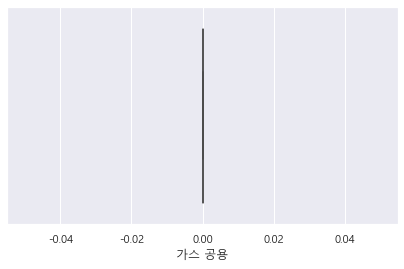

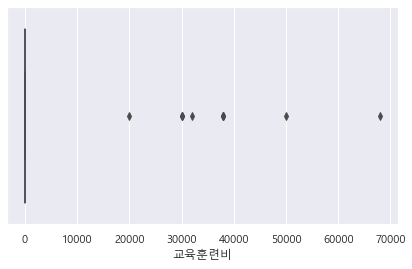

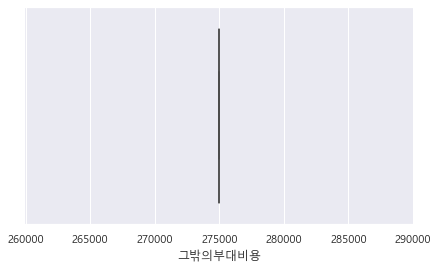

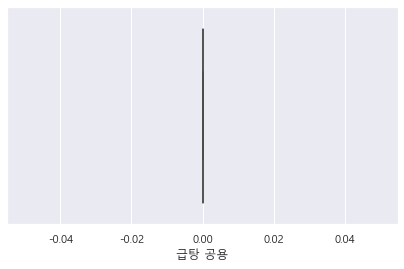

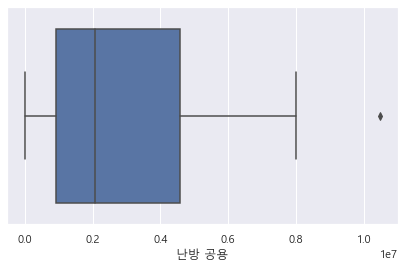

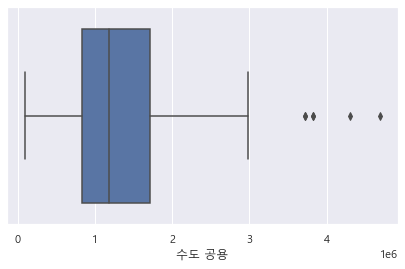

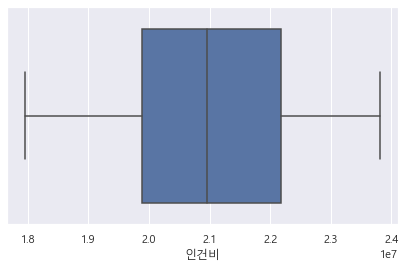

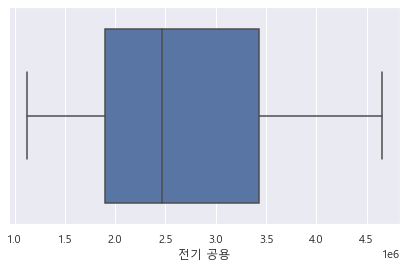

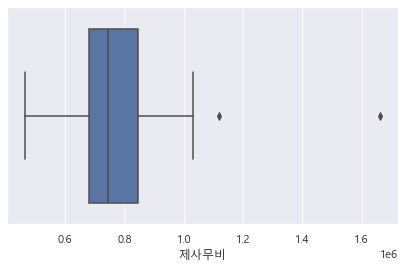

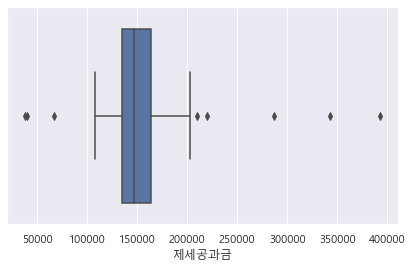

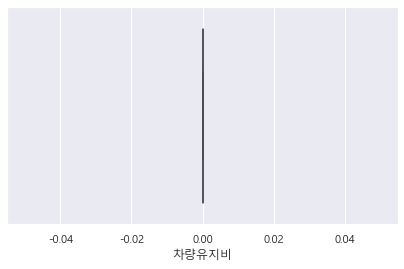

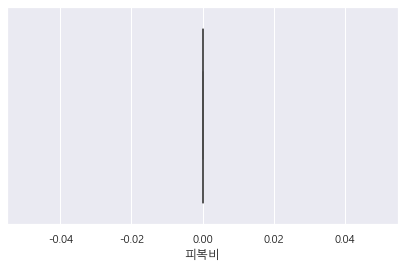

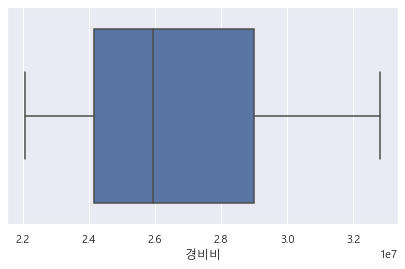

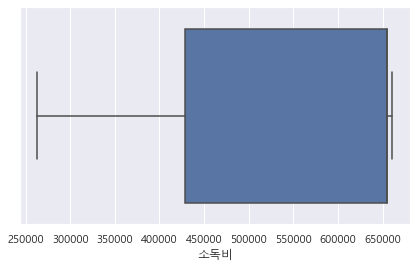

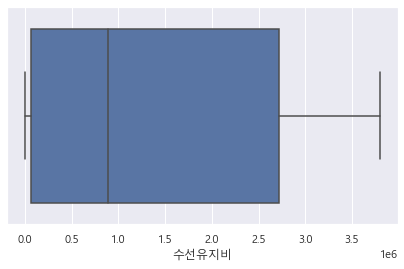

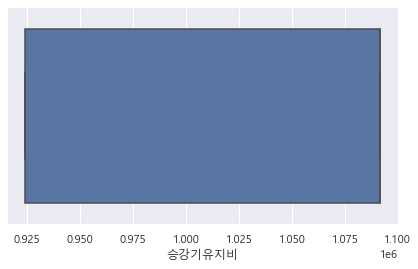

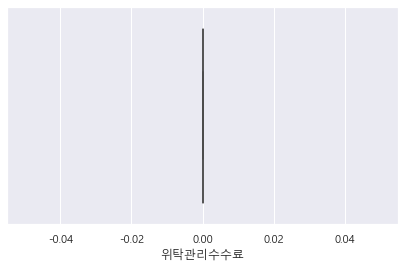

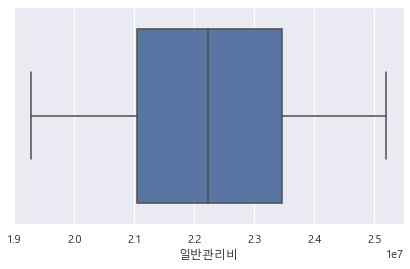

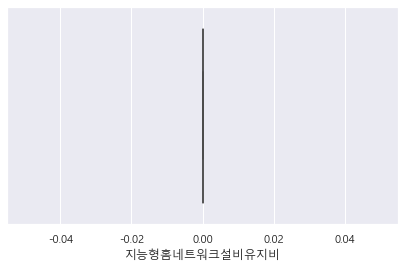

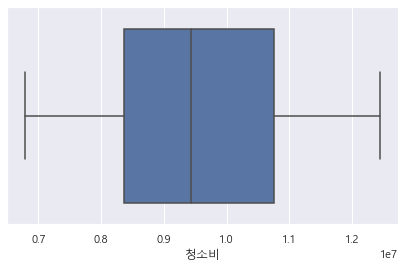

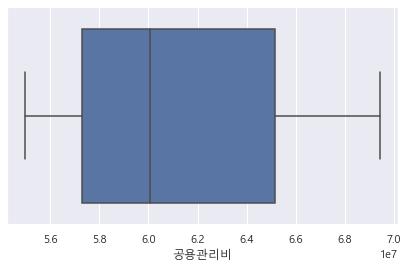

In [8]:
for col in data.columns[1:]:
#    Q1,Q3 = data[col].describe()[4],data[col].describe()[6]
    fig,ax=plt.subplots(figsize=(7,4))
    sns.boxplot(x=data[col],ax=ax)
plt.show()

## __1.2 이상치 판별 함수__

In [9]:
def is_outlier(value,category):
    global data

    if category=='Date' or category not in data.columns:
        print('Wrong or Invalid column name')
        return
    
    Q1,Q3 = data[category].describe()[4],data[category].describe()[6]
    IQR = Q3-Q1
    left_bound = Q1-(1.5*IQR)
    right_bound=Q3+(1.5*IQR)
    
    if (left_bound<=value<=right_bound):
        print('Not outlier')
        return
    
    print('Outlier')
    return
    

is_outlier(16000000,'인건비')
is_outlier(850000,'제사무비')

Outlier
Not outlier


## __2. 월 , 분기 , 연 단위 비용 변화 시각화__

In [10]:
data.Date = data.Date.astype('datetime64[ns]')

In [11]:
data['월']=data.Date.dt.month
data['분기']=pd.cut(data.Date.dt.month,4).values.codes+1
data['년']=data.Date.dt.year

__월별__

Text(0.2, 0.5, '여름엔 감소 , 겨울엔 증가한다')

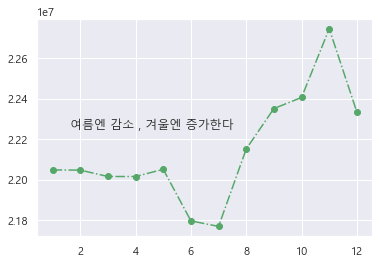

In [12]:
plt.plot(data['월'].unique() , data.groupby(['월'])['일반관리비'].mean(),'g-.o')
fig = plt.gcf()
fig.text(0.2,0.5,'여름엔 감소 , 겨울엔 증가한다')

__분기별__

Text(0.2, 0.5, '월별 결과와 비슷. 3,4 분기가 비용이 크다')

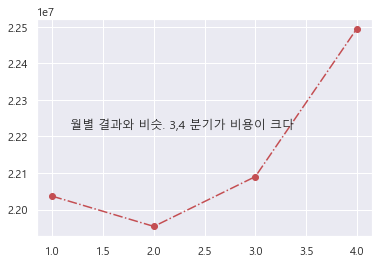

In [13]:
plt.plot(data['분기'].unique() , data.groupby(['분기'])['일반관리비'].mean(),'r-.o')
fig = plt.gcf()
fig.text(0.2,0.5,'월별 결과와 비슷. 3,4 분기가 비용이 크다')

__연도별__

Text(0.15, 0.5, '매년 증가하고 있다. 2018->2019 사이 상승폭이 좁다')

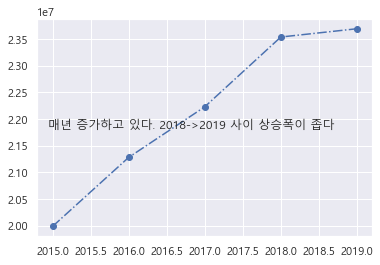

In [14]:
plt.plot(data['년'].unique() , data.groupby(['년'])['일반관리비'].mean(),'b-.o')
fig = plt.gcf()
fig.text(0.15,0.5,'매년 증가하고 있다. 2018->2019 사이 상승폭이 좁다')

## 3. 상관 분석

In [15]:
heat = data.drop(['Date','월','분기','년','가스 공용','그밖의부대비용',
           '급탕 공용','차량유지비','피복비','위탁관리수수료',
           '지능형홈네트워크설비유지비'],axis=1).corr(method='spearman')

<AxesSubplot:>

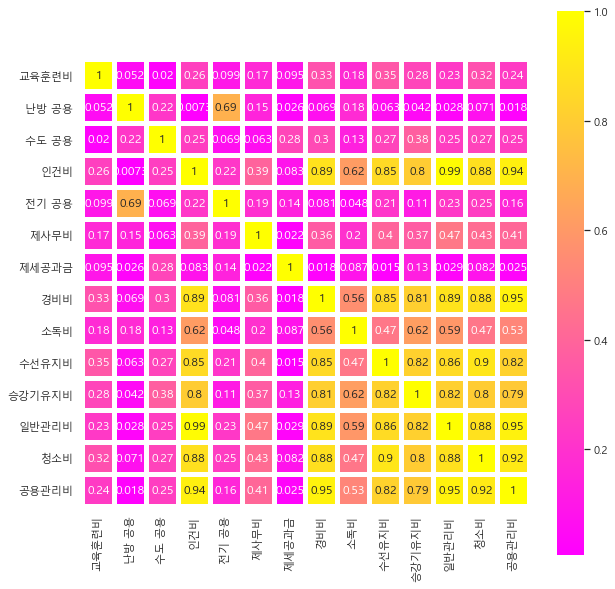

In [16]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(heat.abs(),square=True,cmap='spring',linewidth=4,annot=True)

## __4. 2020.01~2021.12 예측__

__공용관리비=일반관리비+청소비+경비비+소독비+승강기유지비+지능형홈네트워크설비유지비+ 수선유지비+ 위탁관리수수료__  
- 예측 제외 대상 : 지능형홈네트워크설비유지비 , 위탁관리수수료 = 0  
  
__일반관리비=인건비+제사무비+제세공과금+그밖의부대비용__  
- 예측 제외 대상 : 그밖의부대비용 = 275000  
  
  
---
머신러닝(SVM, RF, LR, NN, ...) 알고리즘, 딥러닝(LSTM) 기타 다양한 알고리즘 사용

__청소비 : LinearRegression__

<AxesSubplot:>

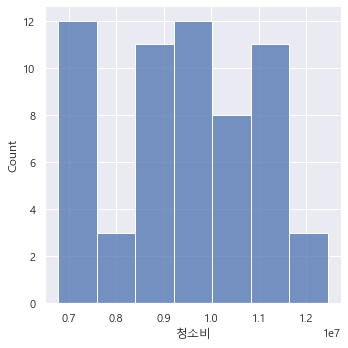

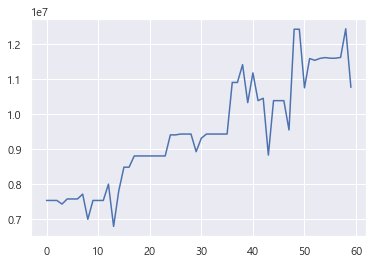

In [17]:
sns.displot(x='청소비',data=data) # 불균형이 심하진 않은것 같으니 StandardScaler
plt.figure()
data['청소비'].plot() 

데이터 전처리 & 분할

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.linear_model import LinearRegression

xdata = data[['년','월','분기']].copy()
ydata = data['청소비'].copy()

M_s = MinMaxScaler()
S_s = StandardScaler()
xdata = M_s.fit_transform(xdata.values)
ydata = S_s.fit_transform(ydata.values.reshape(-1,1))

xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2) # 8:2

학습 & 성능 확인

In [19]:
LR = LinearRegression()
LR.fit(xtrain,ytrain)
print(f'R-square score : {LR.score(xtest,ytest)}')

R-square score : 0.9726383164283251


청소비 예측 : 2020.01 ~ 2021.12

In [20]:
cleaning_fee_predict_x = np.array(np.c_[[2020]*12+[2021]*12,list(range(1,13))*2,[1,1,1,2,2,2,3,3,3,4,4,4]*2])

cleaning_fee_predict_x = M_s.transform(cleaning_fee_predict_x)

cleaning_fee_predict_y = S_s.inverse_transform(LR.predict(cleaning_fee_predict_x))

예측값 시각화

Text(0.5, 1.0, '청소비 예측')

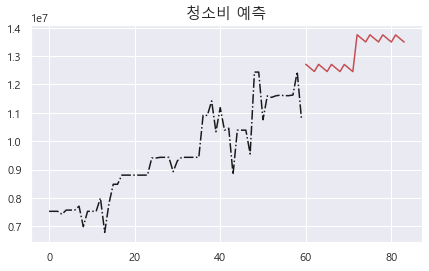

In [21]:
plt.figure(figsize=(7,4))
plt.plot(data['청소비'],'k-.')
plt.plot(pd.Series(cleaning_fee_predict_y.ravel(),index=range(60,84)),'r-')
ax = plt.gca()
ax.set_title('청소비 예측',fontsize=15)

__경비비 : RandomForestRegressor__

<AxesSubplot:>

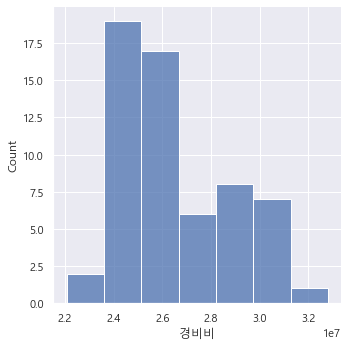

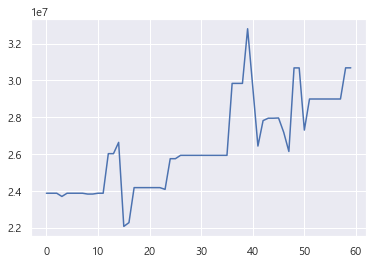

In [22]:
sns.displot(x='경비비',data=data) # 불균형이 심하진 않은것 같으니 StandardScaler
plt.figure()
data['경비비'].plot() 

데이터 전처리 & 분할

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor

xdata = data[['년','월','분기']].copy()
ydata = data['경비비'].copy()

M_s = MinMaxScaler()
S_s = StandardScaler()
xdata = M_s.fit_transform(xdata.values)
ydata = S_s.fit_transform(ydata.values.reshape(-1,1))

xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2) # 8:2

학습 & 성능 확인

In [24]:
RFR = RandomForestRegressor(n_estimators=20,random_state=1120)
RFR.fit(xtrain,ytrain)
print(f'R-square score : {RFR.score(xtest,ytest)}')

R-square score : 0.9273508333621916


경비비 예측 : 2020.01 ~ 2021.12

In [25]:
securityguard_fee_predict_x = np.array(np.c_[[2020]*12+[2021]*12,list(range(1,13))*2,[1,1,1,2,2,2,3,3,3,4,4,4]*2])

securityguard_fee_predict_x = M_s.transform(securityguard_fee_predict_x)

securityguard_fee_predict_y = S_s.inverse_transform(RFR.predict(securityguard_fee_predict_x))

예측값 시각화

Text(0.5, 1.0, '경비비 예측')

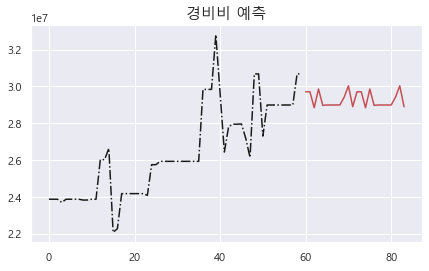

In [26]:
plt.figure(figsize=(7,4))
plt.plot(data['경비비'],'k-.')
plt.plot(pd.Series(securityguard_fee_predict_y.ravel(),index=range(60,84)),'r-')
ax = plt.gca()
ax.set_title('경비비 예측',fontsize=15)

__소독비 : 예측 포기__

<AxesSubplot:>

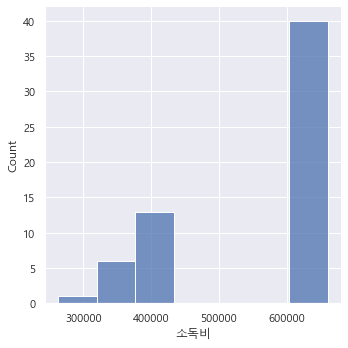

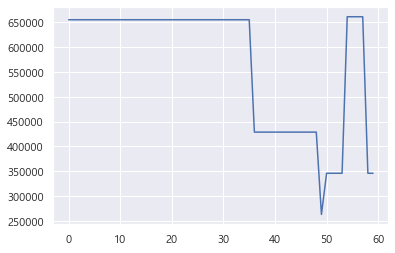

In [27]:
sns.displot(x='소독비',data=data) # 불균형 MinMaxScaler
plt.figure()
data['소독비'].plot() # 예측이 불가해 보임 : 마지막 값으로 상수 예측

In [28]:
disinfection_fee_predict_y=np.array([data['소독비'].iloc[-1]]*24)

예측값 시각화

Text(0.5, 1.0, '소독비 예측')

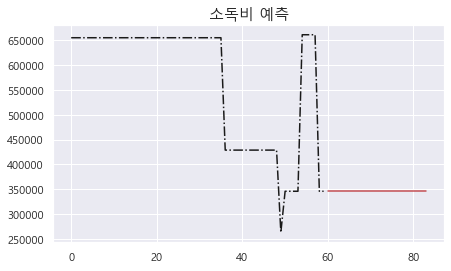

In [29]:
plt.figure(figsize=(7,4))
plt.plot(data['소독비'],'k-.')
plt.plot(pd.Series(disinfection_fee_predict_y.ravel(),index=range(60,84)),'r-')
ax = plt.gca()
ax.set_title('소독비 예측',fontsize=15)

__승강기유지비 : 예측 포기__

<AxesSubplot:>

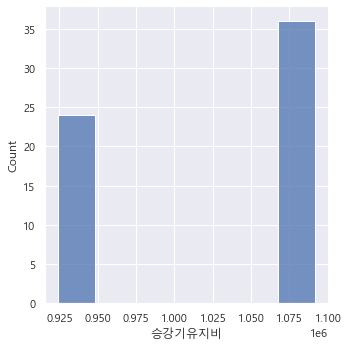

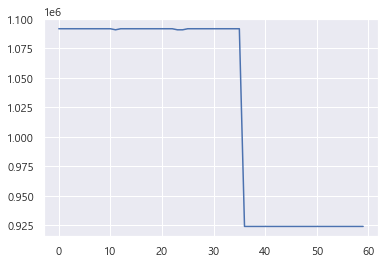

In [30]:
sns.displot(x='승강기유지비',data=data) # 불균형 MinMaxScaler
plt.figure()
data['승강기유지비'].plot() # 예측이 불가해 보임 : 3년 단위 ?

In [31]:
value = [data['승강기유지비'].iloc[-1]]*12+[data['승강기유지비'].iloc[-1]*(data['승강기유지비'].iloc[-1]/data['승강기유지비'].iloc[0])]*12
EV_maintenance_fee_predict_y=np.array(value)

Text(0.5, 1.0, '승강기유지비 예측')

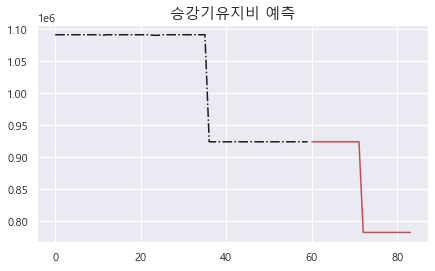

In [32]:
plt.figure(figsize=(7,4))
plt.plot(data['승강기유지비'],'k-.')
plt.plot(pd.Series(EV_maintenance_fee_predict_y.ravel(),index=range(60,84)),'r-')
ax = plt.gca()
ax.set_title('승강기유지비 예측',fontsize=15)

__수선유지비 : NN__

<AxesSubplot:>

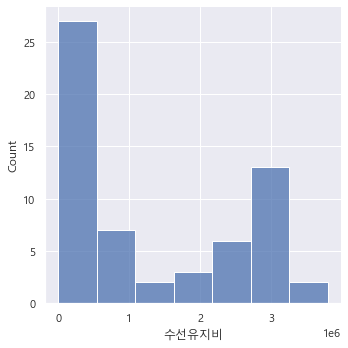

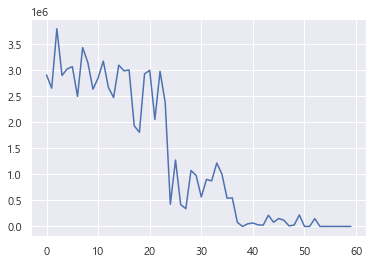

In [33]:
sns.displot(x='수선유지비',data=data) # 불균형이 심하진 않은것 같으니 StandardScaler
plt.figure()
data['수선유지비'].plot() 

데이터 전처리 & 분할 : 10^5 수준으로 내려온 구간만 활용

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.svm import SVR

xdata = data[['년','월','분기']].iloc[37:].copy()
ydata = data['수선유지비'].iloc[37:].copy()

M_s = MinMaxScaler()
S_s = StandardScaler()
xdata = M_s.fit_transform(xdata.values)
ydata = S_s.fit_transform(ydata.values.reshape(-1,1))

xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2) # 8:2

학습 & 성능 확인

In [35]:
from keras.models import Sequential
from keras.layers import Activation,Dense

model = Sequential()
model.add(Dense(units=5, input_dim=3 , activation='relu'))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(loss= 'mse' , optimizer='adam' , metrics=['mse'])

model.fit(xtrain,ytrain,epochs=100,batch_size=4,validation_data=(xtest,ytest))

Epoch 1/100
5/5 [==============================] - 0s 29ms/step - loss: 1.4568 - mse: 1.4568 - val_loss: 0.1200 - val_mse: 0.1200
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 1.4072 - mse: 1.4072 - val_loss: 0.1337 - val_mse: 0.1337
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 1.3702 - mse: 1.3702 - val_loss: 0.1500 - val_mse: 0.1500
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 1.3231 - mse: 1.3231 - val_loss: 0.1652 - val_mse: 0.1652
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 1.2986 - mse: 1.2986 - val_loss: 0.1830 - val_mse: 0.1830
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 1.2646 - mse: 1.2646 - val_loss: 0.2006 - val_mse: 0.2006
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 1.2349 - mse: 1.2349 - val_loss: 0.2158 - val_mse: 0.2158
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 1.2123 - mse: 1.2123 - va

5/5 [==============================] - 0s 5ms/step - loss: 0.9491 - mse: 0.9491 - val_loss: 0.6395 - val_mse: 0.6395
Epoch 65/100
5/5 [==============================] - 0s 4ms/step - loss: 0.9475 - mse: 0.9475 - val_loss: 0.6374 - val_mse: 0.6374
Epoch 66/100
5/5 [==============================] - 0s 4ms/step - loss: 0.9458 - mse: 0.9458 - val_loss: 0.6349 - val_mse: 0.6349
Epoch 67/100
5/5 [==============================] - 0s 5ms/step - loss: 0.9446 - mse: 0.9446 - val_loss: 0.6319 - val_mse: 0.6319
Epoch 68/100
5/5 [==============================] - 0s 4ms/step - loss: 0.9427 - mse: 0.9427 - val_loss: 0.6329 - val_mse: 0.6329
Epoch 69/100
5/5 [==============================] - 0s 4ms/step - loss: 0.9410 - mse: 0.9410 - val_loss: 0.6321 - val_mse: 0.6321
Epoch 70/100
5/5 [==============================] - 0s 4ms/step - loss: 0.9385 - mse: 0.9385 - val_loss: 0.6359 - val_mse: 0.6359
Epoch 71/100
5/5 [==============================] - 0s 5ms/step - loss: 0.9371 - mse: 0.9371 - val_loss

수선유지비 예측 : 2020.01 ~ 2021.12

In [36]:
appurtenance_fee_predict_x = np.array(np.c_[[2020]*12+[2021]*12,list(range(1,13))*2,[1,1,1,2,2,2,3,3,3,4,4,4]*2])

appurtenance_fee_predict_x = M_s.transform(appurtenance_fee_predict_x)

appurtenance_fee_predict_y = S_s.inverse_transform(model.predict(appurtenance_fee_predict_x))

appurtenance_fee_predict_y = pd.Series(appurtenance_fee_predict_y.ravel()).map(lambda x : max(0,x)).values

예측값 시각화

Text(0.5, 1.0, '수선유지비 예측')

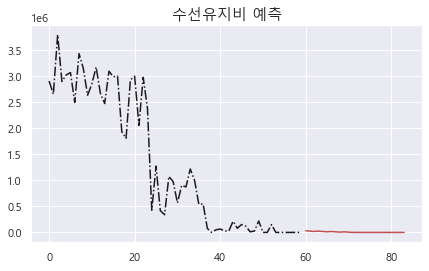

In [37]:
plt.figure(figsize=(7,4))
plt.plot(data['수선유지비'],'k-.')
plt.plot(pd.Series(appurtenance_fee_predict_y.ravel(),index=range(60,84)),'r-')
ax = plt.gca()
ax.set_title('수선유지비 예측',fontsize=15)

__인건비 , 제사무비 , 제세공과금 : LSTM__

<AxesSubplot:>

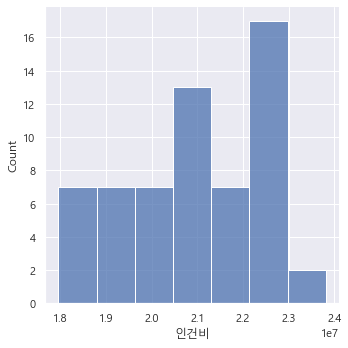

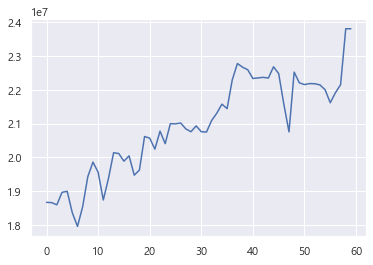

In [38]:
sns.displot(x='인건비',data=data) # 불균형이 심하진 않은것 같으니 StandardScaler
plt.figure()
data['인건비'].plot() 

<AxesSubplot:>

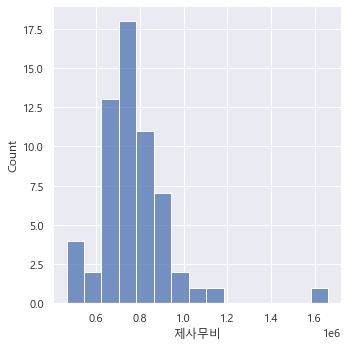

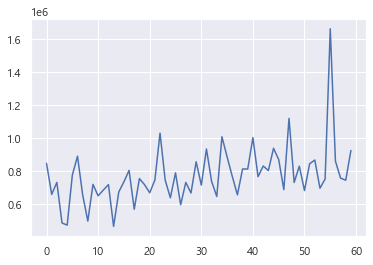

In [39]:
sns.displot(x='제사무비',data=data) # 불균형이 심하진 않은것 같으니 StandardScaler
plt.figure()
data['제사무비'].plot() 

<AxesSubplot:>

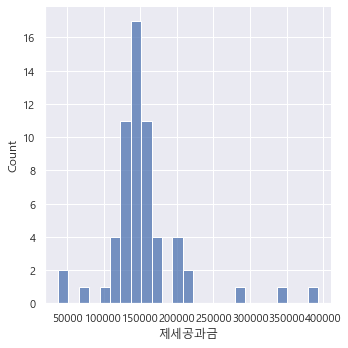

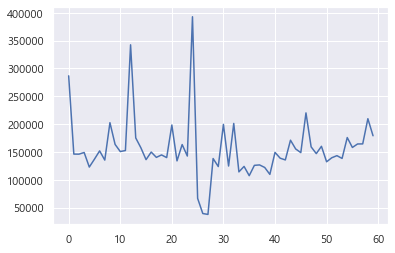

In [40]:
sns.displot(x='제세공과금',data=data) # 불균형이 심하진 않은것 같으니 StandardScaler
plt.figure()
data['제세공과금'].plot() 

데이터 전처리 & 분할

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

raw_data = data[['인건비','제사무비','제세공과금']].values.copy()

S_s = StandardScaler()
raw_data = S_s.fit_transform(raw_data)

window_size = 6
xdata,ydata=[],[]

for i in range(data.shape[0]-window_size):
    xdata.append([raw_data[i+j].tolist() for j in range(window_size)])
    ydata.append(raw_data[window_size+i].tolist())
    
xdata= np.array(xdata)
ydata= np.array(ydata).reshape(-1,1,raw_data.shape[-1])

xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2) # 8:2

학습 & 성능 확인

In [58]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, TimeDistributed

xInput = Input(batch_shape=(None, window_size, 3))
#xLstm = LSTM(8, return_sequences=True)(xInput)
#xOutput = TimeDistributed(Dense(3))(xLstm)
xLstm = LSTM(5)(xInput)
xOutput = Dense(3)(xLstm)
model = Model(xInput, xOutput)

model.compile(loss='mse', optimizer='adam',metrics=['mse'])

model.fit(xtrain,ytrain,epochs=150,batch_size=1,validation_data=(xtest,ytest))

Epoch 1/150
43/43 [==============================] - 0s 10ms/step - loss: 0.9419 - mse: 0.9419 - val_loss: 0.5442 - val_mse: 0.5442
Epoch 2/150
43/43 [==============================] - 0s 2ms/step - loss: 0.8989 - mse: 0.8989 - val_loss: 0.5024 - val_mse: 0.5024
Epoch 3/150
43/43 [==============================] - 0s 2ms/step - loss: 0.8656 - mse: 0.8656 - val_loss: 0.4710 - val_mse: 0.4710
Epoch 4/150
43/43 [==============================] - 0s 2ms/step - loss: 0.8419 - mse: 0.8419 - val_loss: 0.4474 - val_mse: 0.4474
Epoch 5/150
43/43 [==============================] - 0s 2ms/step - loss: 0.8212 - mse: 0.8212 - val_loss: 0.4285 - val_mse: 0.4285
Epoch 6/150
43/43 [==============================] - 0s 2ms/step - loss: 0.8030 - mse: 0.8030 - val_loss: 0.4129 - val_mse: 0.4129
Epoch 7/150
43/43 [==============================] - 0s 2ms/step - loss: 0.7892 - mse: 0.7892 - val_loss: 0.4003 - val_mse: 0.4003
Epoch 8/150
43/43 [==============================] - 0s 2ms/step - loss: 0.7779 - 

43/43 [==============================] - 0s 2ms/step - loss: 0.5700 - mse: 0.5700 - val_loss: 0.3947 - val_mse: 0.3947
Epoch 64/150
43/43 [==============================] - 0s 2ms/step - loss: 0.5673 - mse: 0.5673 - val_loss: 0.3985 - val_mse: 0.3985
Epoch 65/150
43/43 [==============================] - 0s 2ms/step - loss: 0.5643 - mse: 0.5643 - val_loss: 0.4007 - val_mse: 0.4007
Epoch 66/150
43/43 [==============================] - 0s 2ms/step - loss: 0.5621 - mse: 0.5621 - val_loss: 0.4003 - val_mse: 0.4003
Epoch 67/150
43/43 [==============================] - 0s 2ms/step - loss: 0.5590 - mse: 0.5590 - val_loss: 0.4021 - val_mse: 0.4021
Epoch 68/150
43/43 [==============================] - 0s 2ms/step - loss: 0.5551 - mse: 0.5551 - val_loss: 0.4039 - val_mse: 0.4039
Epoch 69/150
43/43 [==============================] - 0s 2ms/step - loss: 0.5535 - mse: 0.5535 - val_loss: 0.4053 - val_mse: 0.4053
Epoch 70/150
43/43 [==============================] - 0s 2ms/step - loss: 0.5494 - mse: 0

Epoch 125/150
43/43 [==============================] - 0s 2ms/step - loss: 0.4273 - mse: 0.4273 - val_loss: 0.4808 - val_mse: 0.4808
Epoch 126/150
43/43 [==============================] - 0s 2ms/step - loss: 0.4250 - mse: 0.4250 - val_loss: 0.4789 - val_mse: 0.4789
Epoch 127/150
43/43 [==============================] - 0s 2ms/step - loss: 0.4241 - mse: 0.4241 - val_loss: 0.4823 - val_mse: 0.4823
Epoch 128/150
43/43 [==============================] - 0s 2ms/step - loss: 0.4233 - mse: 0.4233 - val_loss: 0.4809 - val_mse: 0.4809
Epoch 129/150
43/43 [==============================] - 0s 2ms/step - loss: 0.4200 - mse: 0.4200 - val_loss: 0.4842 - val_mse: 0.4842
Epoch 130/150
43/43 [==============================] - 0s 2ms/step - loss: 0.4186 - mse: 0.4186 - val_loss: 0.4822 - val_mse: 0.4822
Epoch 131/150
43/43 [==============================] - 0s 2ms/step - loss: 0.4192 - mse: 0.4192 - val_loss: 0.4765 - val_mse: 0.4765
Epoch 132/150
43/43 [==============================] - 0s 2ms/step - 

인건비 , 제사무비 , 제세공과금 예측 : 2020.01 ~ 2021.12

In [59]:
nPredict = 24

LSTM_predict_x = raw_data[-window_size:]
LSTM_predict_y = []

for _ in range(nPredict):
    yhat = model.predict(LSTM_predict_x.reshape(1,window_size,-1))
    LSTM_predict_y.append(S_s.inverse_transform(yhat).ravel().tolist())
    LSTM_predict_x = np.concatenate((LSTM_predict_x[1:],yhat),axis=0)

예측값 시각화 : 인건비

Text(0.5, 1.0, '인건비 예측')

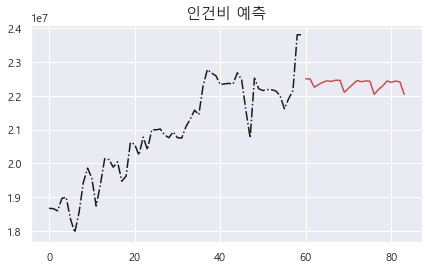

In [60]:
plt.figure(figsize=(7,4))
plt.plot(data['인건비'],'k-.')
plt.plot(pd.DataFrame(LSTM_predict_y,index=range(60,84))[0],'r-')
ax = plt.gca()
ax.set_title('인건비 예측',fontsize=15)

Text(0.5, 1.0, '제사무비 예측')

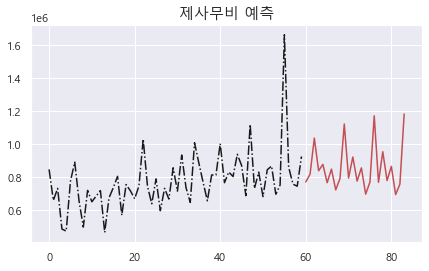

In [61]:
plt.figure(figsize=(7,4))
plt.plot(data['제사무비'],'k-.')
plt.plot(pd.DataFrame(LSTM_predict_y,index=range(60,84))[1],'r-')
ax = plt.gca()
ax.set_title('제사무비 예측',fontsize=15)

Text(0.5, 1.0, '제세공과금 예측')

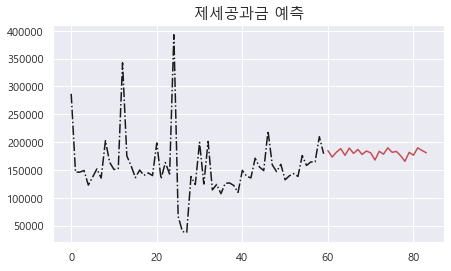

In [62]:
plt.figure(figsize=(7,4))
plt.plot(data['제세공과금'],'k-.')
plt.plot(pd.DataFrame(LSTM_predict_y,index=range(60,84))[2],'r-')
ax = plt.gca()
ax.set_title('제세공과금 예측',fontsize=15)

__일반관리비 , 공용관리비 예측값 연산__

일반관리비=인건비+제사무비+제세공과금+그밖의부대비용(275000)

In [63]:
maintenance_fees_predict = np.array(LSTM_predict_y).sum(axis=1)

Text(0.5, 1.0, '일반관리비 예측')

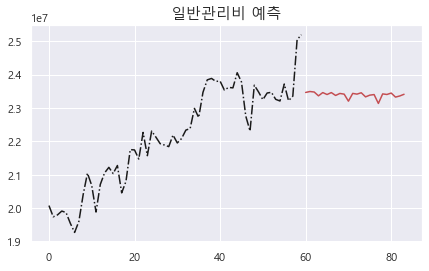

In [64]:
plt.figure(figsize=(7,4))
plt.plot(data['일반관리비'],'k-.')
plt.plot(pd.Series(maintenance_fees_predict,index=range(60,84)),'r-')
ax = plt.gca()
ax.set_title('일반관리비 예측',fontsize=15)

공용관리비=일반관리비+청소비+경비비+소독비+승강기유지비+  
\ \ \ \ \ \ \ 지능형홈네트워크설비유지비(0)+ 수선유지비+ 위탁관리수수료(0)

In [65]:
common_maintenance_fees_predict = (maintenance_fees_predict+
                                   cleaning_fee_predict_y.ravel()+
                                   securityguard_fee_predict_y+
                                   disinfection_fee_predict_y+
                                   EV_maintenance_fee_predict_y+
                                   appurtenance_fee_predict_y)


Text(0.5, 1.0, '공용관리비 예측')

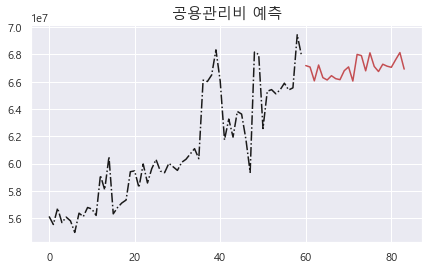

In [66]:
plt.figure(figsize=(7,4))
plt.plot(data['공용관리비'],'k-.')
plt.plot(pd.Series(common_maintenance_fees_predict,index=range(60,84)),'r-')
ax = plt.gca()
ax.set_title('공용관리비 예측',fontsize=15)

In [67]:
으앆

NameError: name '으앆' is not defined